# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import SVHN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# Optional: you can keep hidden_dims or increase due to higher input size
hidden_dims = [512, 256]  # Suggested for SVHN, but your choice

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics (unchanged)
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3156 | Test Loss 2.3875 | accs Train 0.0667 Test 0.1461


Epoch 100/2000: Train Loss 0.0000 | Test Loss 10.1807 | accs Train 1.0000 Test 0.1732


Epoch 200/2000: Train Loss 0.0000 | Test Loss 10.1785 | accs Train 1.0000 Test 0.1717


Epoch 300/2000: Train Loss 0.0000 | Test Loss 10.1635 | accs Train 1.0000 Test 0.1727


Epoch 400/2000: Train Loss 0.0000 | Test Loss 10.1578 | accs Train 1.0000 Test 0.1731


Epoch 500/2000: Train Loss 0.0000 | Test Loss 10.1607 | accs Train 1.0000 Test 0.1731


Epoch 600/2000: Train Loss 0.0000 | Test Loss 10.1672 | accs Train 1.0000 Test 0.1737


Epoch 700/2000: Train Loss 0.0000 | Test Loss 10.1763 | accs Train 1.0000 Test 0.1741


Epoch 800/2000: Train Loss 0.0000 | Test Loss 10.1890 | accs Train 1.0000 Test 0.1747


Epoch 900/2000: Train Loss 0.0000 | Test Loss 10.2034 | accs Train 1.0000 Test 0.1751


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 10.2194 | accs Train 1.0000 Test 0.1753


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 10.2379 | accs Train 1.0000 Test 0.1756


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 10.2533 | accs Train 1.0000 Test 0.1760


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 10.2671 | accs Train 1.0000 Test 0.1761


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 10.2810 | accs Train 1.0000 Test 0.1763


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 10.2960 | accs Train 1.0000 Test 0.1764


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 10.3111 | accs Train 1.0000 Test 0.1763


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 10.3289 | accs Train 1.0000 Test 0.1764


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 10.3472 | accs Train 1.0000 Test 0.1766


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 10.3620 | accs Train 1.0000 Test 0.1766


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 10.3763 | accs Train 1.0000 Test 0.1771
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3257 | Test Loss 2.3871 | accs Train 0.0783 Test 0.1967


Epoch 100/2000: Train Loss 0.0027 | Test Loss 4.1793 | accs Train 1.0000 Test 0.4417


Epoch 200/2000: Train Loss 0.0009 | Test Loss 4.5938 | accs Train 1.0000 Test 0.4430


Epoch 300/2000: Train Loss 0.0005 | Test Loss 4.8447 | accs Train 1.0000 Test 0.4440


Epoch 400/2000: Train Loss 0.0003 | Test Loss 5.0283 | accs Train 1.0000 Test 0.4442


Epoch 500/2000: Train Loss 0.0002 | Test Loss 5.1722 | accs Train 1.0000 Test 0.4451


Epoch 600/2000: Train Loss 0.0001 | Test Loss 5.2906 | accs Train 1.0000 Test 0.4453


Epoch 700/2000: Train Loss 0.0001 | Test Loss 5.3912 | accs Train 1.0000 Test 0.4455


Epoch 800/2000: Train Loss 0.0001 | Test Loss 5.4787 | accs Train 1.0000 Test 0.4456


Epoch 900/2000: Train Loss 0.0001 | Test Loss 5.5571 | accs Train 1.0000 Test 0.4458


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.6288 | accs Train 1.0000 Test 0.4460


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 5.6937 | accs Train 1.0000 Test 0.4464


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 5.7542 | accs Train 1.0000 Test 0.4463


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 5.8092 | accs Train 1.0000 Test 0.4466


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 5.8601 | accs Train 1.0000 Test 0.4471


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 5.9073 | accs Train 1.0000 Test 0.4475


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 5.9515 | accs Train 1.0000 Test 0.4476


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.9928 | accs Train 1.0000 Test 0.4479


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 6.0322 | accs Train 1.0000 Test 0.4481


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 6.0696 | accs Train 1.0000 Test 0.4479


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 6.1054 | accs Train 1.0000 Test 0.4479
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3202 | Test Loss 2.3438 | accs Train 0.0835 Test 0.1932


Epoch 100/2000: Train Loss 0.0279 | Test Loss 2.1990 | accs Train 1.0000 Test 0.5928


Epoch 200/2000: Train Loss 0.0035 | Test Loss 2.8088 | accs Train 1.0000 Test 0.5917


Epoch 300/2000: Train Loss 0.0014 | Test Loss 3.0765 | accs Train 1.0000 Test 0.5920


Epoch 400/2000: Train Loss 0.0008 | Test Loss 3.2609 | accs Train 1.0000 Test 0.5918


Epoch 500/2000: Train Loss 0.0005 | Test Loss 3.3991 | accs Train 1.0000 Test 0.5925


Epoch 600/2000: Train Loss 0.0004 | Test Loss 3.5117 | accs Train 1.0000 Test 0.5925


Epoch 700/2000: Train Loss 0.0003 | Test Loss 3.6063 | accs Train 1.0000 Test 0.5922


Epoch 800/2000: Train Loss 0.0002 | Test Loss 3.6898 | accs Train 1.0000 Test 0.5922


Epoch 900/2000: Train Loss 0.0002 | Test Loss 3.7640 | accs Train 1.0000 Test 0.5917


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 3.8288 | accs Train 1.0000 Test 0.5924


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 3.8864 | accs Train 1.0000 Test 0.5923


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 3.9410 | accs Train 1.0000 Test 0.5925


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 3.9904 | accs Train 1.0000 Test 0.5927


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 4.0360 | accs Train 1.0000 Test 0.5927


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 4.0806 | accs Train 1.0000 Test 0.5923


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 4.1216 | accs Train 1.0000 Test 0.5925


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 4.1604 | accs Train 1.0000 Test 0.5923


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 4.1977 | accs Train 1.0000 Test 0.5926


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 4.2330 | accs Train 1.0000 Test 0.5927


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 4.2651 | accs Train 1.0000 Test 0.5929
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3185 | Test Loss 2.3336 | accs Train 0.0810 Test 0.1926


Epoch 100/2000: Train Loss 0.4248 | Test Loss 1.3354 | accs Train 0.8735 Test 0.6509


Epoch 200/2000: Train Loss 0.6572 | Test Loss 1.4411 | accs Train 0.7833 Test 0.6052


Epoch 300/2000: Train Loss 0.0641 | Test Loss 1.5291 | accs Train 0.9968 Test 0.6991


Epoch 400/2000: Train Loss 0.0233 | Test Loss 1.7689 | accs Train 0.9998 Test 0.6995


Epoch 500/2000: Train Loss 0.0117 | Test Loss 1.9407 | accs Train 1.0000 Test 0.6984


Epoch 600/2000: Train Loss 0.0070 | Test Loss 2.0704 | accs Train 1.0000 Test 0.6985


Epoch 700/2000: Train Loss 0.0046 | Test Loss 2.1749 | accs Train 1.0000 Test 0.6982


Epoch 800/2000: Train Loss 0.0033 | Test Loss 2.2620 | accs Train 1.0000 Test 0.6983


Epoch 900/2000: Train Loss 0.0025 | Test Loss 2.3384 | accs Train 1.0000 Test 0.6983


Epoch 1000/2000: Train Loss 0.0019 | Test Loss 2.4062 | accs Train 1.0000 Test 0.6978


Epoch 1100/2000: Train Loss 0.0015 | Test Loss 2.4670 | accs Train 1.0000 Test 0.6971


Epoch 1200/2000: Train Loss 0.0012 | Test Loss 2.5220 | accs Train 1.0000 Test 0.6976


Epoch 1300/2000: Train Loss 0.0010 | Test Loss 2.5714 | accs Train 1.0000 Test 0.6971


Epoch 1400/2000: Train Loss 0.0009 | Test Loss 2.6176 | accs Train 1.0000 Test 0.6976


Epoch 1500/2000: Train Loss 0.0007 | Test Loss 2.6594 | accs Train 1.0000 Test 0.6976


Epoch 1600/2000: Train Loss 0.0006 | Test Loss 2.6990 | accs Train 1.0000 Test 0.6977


Epoch 1700/2000: Train Loss 0.0005 | Test Loss 2.7354 | accs Train 1.0000 Test 0.6979


Epoch 1800/2000: Train Loss 0.0005 | Test Loss 2.7699 | accs Train 1.0000 Test 0.6976


Epoch 1900/2000: Train Loss 0.0004 | Test Loss 2.8027 | accs Train 1.0000 Test 0.6978


Epoch 2000/2000: Train Loss 0.0004 | Test Loss 2.8339 | accs Train 1.0000 Test 0.6979
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3173 | Test Loss 2.3367 | accs Train 0.0822 Test 0.1958


Epoch 100/2000: Train Loss 0.6050 | Test Loss 0.9986 | accs Train 0.8208 Test 0.7145


Epoch 200/2000: Train Loss 0.5111 | Test Loss 0.9800 | accs Train 0.8399 Test 0.7283


Epoch 300/2000: Train Loss 0.2069 | Test Loss 0.9559 | accs Train 0.9473 Test 0.7741


Epoch 400/2000: Train Loss 0.9095 | Test Loss 1.1463 | accs Train 0.7117 Test 0.6491


Epoch 500/2000: Train Loss 0.2230 | Test Loss 0.9283 | accs Train 0.9426 Test 0.7783


Epoch 600/2000: Train Loss 0.1064 | Test Loss 1.0403 | accs Train 0.9829 Test 0.7838


Epoch 700/2000: Train Loss 0.0660 | Test Loss 1.1457 | accs Train 0.9932 Test 0.7866


Epoch 800/2000: Train Loss 0.0371 | Test Loss 1.2601 | accs Train 0.9979 Test 0.7866


Epoch 900/2000: Train Loss 0.0222 | Test Loss 1.3684 | accs Train 0.9996 Test 0.7859


Epoch 1000/2000: Train Loss 0.0145 | Test Loss 1.4605 | accs Train 1.0000 Test 0.7851


Epoch 1100/2000: Train Loss 0.0101 | Test Loss 1.5397 | accs Train 1.0000 Test 0.7847


Epoch 1200/2000: Train Loss 0.0074 | Test Loss 1.6090 | accs Train 1.0000 Test 0.7837


Epoch 1300/2000: Train Loss 0.0057 | Test Loss 1.6708 | accs Train 1.0000 Test 0.7840


Epoch 1400/2000: Train Loss 0.0045 | Test Loss 1.7249 | accs Train 1.0000 Test 0.7842


Epoch 1500/2000: Train Loss 0.0036 | Test Loss 1.7739 | accs Train 1.0000 Test 0.7836


Epoch 1600/2000: Train Loss 0.0030 | Test Loss 1.8183 | accs Train 1.0000 Test 0.7833


Epoch 1700/2000: Train Loss 0.0025 | Test Loss 1.8591 | accs Train 1.0000 Test 0.7833


Epoch 1800/2000: Train Loss 0.0021 | Test Loss 1.8969 | accs Train 1.0000 Test 0.7832


Epoch 1900/2000: Train Loss 0.0018 | Test Loss 1.9324 | accs Train 1.0000 Test 0.7832


Epoch 2000/2000: Train Loss 0.0016 | Test Loss 1.9660 | accs Train 1.0000 Test 0.7829
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3183 | Test Loss 2.3312 | accs Train 0.0820 Test 0.2026


Epoch 100/2000: Train Loss 0.6805 | Test Loss 0.8806 | accs Train 0.7974 Test 0.7436


Epoch 200/2000: Train Loss 0.4371 | Test Loss 0.7122 | accs Train 0.8718 Test 0.8074


Epoch 300/2000: Train Loss 0.9293 | Test Loss 0.9930 | accs Train 0.7209 Test 0.7131


Epoch 400/2000: Train Loss 0.2931 | Test Loss 0.6598 | accs Train 0.9200 Test 0.8305


Epoch 500/2000: Train Loss 0.2178 | Test Loss 0.6800 | accs Train 0.9435 Test 0.8344


Epoch 600/2000: Train Loss 0.4720 | Test Loss 0.7264 | accs Train 0.8608 Test 0.8003


Epoch 700/2000: Train Loss 0.3508 | Test Loss 0.7297 | accs Train 0.8944 Test 0.8152


Epoch 800/2000: Train Loss 0.2622 | Test Loss 0.7464 | accs Train 0.9243 Test 0.8186


Epoch 900/2000: Train Loss 0.2004 | Test Loss 0.7234 | accs Train 0.9474 Test 0.8349


Epoch 1000/2000: Train Loss 0.7233 | Test Loss 1.2146 | accs Train 0.8467 Test 0.7696


Epoch 1100/2000: Train Loss 0.1937 | Test Loss 0.7429 | accs Train 0.9482 Test 0.8347


Epoch 1200/2000: Train Loss 0.1390 | Test Loss 0.7923 | accs Train 0.9671 Test 0.8357


Epoch 1300/2000: Train Loss 0.5767 | Test Loss 0.8383 | accs Train 0.8235 Test 0.7638


Epoch 1400/2000: Train Loss 0.3520 | Test Loss 0.7389 | accs Train 0.8947 Test 0.8104


Epoch 1500/2000: Train Loss 0.2636 | Test Loss 0.7244 | accs Train 0.9252 Test 0.8244


Epoch 1600/2000: Train Loss 0.2349 | Test Loss 0.7618 | accs Train 0.9329 Test 0.8244


Epoch 1700/2000: Train Loss 1.4947 | Test Loss 1.8791 | accs Train 0.5729 Test 0.4987


Epoch 1800/2000: Train Loss 0.2972 | Test Loss 0.7308 | accs Train 0.9143 Test 0.8257


Epoch 1900/2000: Train Loss 0.2102 | Test Loss 0.7551 | accs Train 0.9430 Test 0.8319


Epoch 2000/2000: Train Loss 0.4379 | Test Loss 0.8283 | accs Train 0.8636 Test 0.7931
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 10.3763 | accs: 0.1771
 540 samples | Test Loss: 6.1054 | accs: 0.4479
1940 samples | Test Loss: 4.2651 | accs: 0.5929
5940 samples | Test Loss: 2.8339 | accs: 0.6979
19940 samples | Test Loss: 1.9660 | accs: 0.7829
59940 samples | Test Loss: 0.8283 | accs: 0.7931

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0004 | accs: 1.0000
 Model 19940 | Train Loss: 0.0013 | accs: 1.0000
 Model 59940 | Train Loss: 0.3570 | accs: 0.9000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 8.0565 | accs: 0.2617
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0004 | accs: 1.0000
 Model 19940 | Train Loss: 0.0015 | accs: 1.0000
 Model 59940 | Tra

 Model 59940 | Train Loss: 0.4354 | accs: 0.8663

Dataset type: data, additional samples: 59940


 Model    0 | Train Loss: 9.8289 | accs: 0.1559
 Model  540 | Train Loss: 5.3046 | accs: 0.4495
 Model 1940 | Train Loss: 3.5242 | accs: 0.6282
 Model 5940 | Train Loss: 2.0780 | accs: 0.7487
 Model 19940 | Train Loss: 1.0149 | accs: 0.8679
 Model 59940 | Train Loss: 0.4300 | accs: 0.8669


### Model + Data Specific Verification

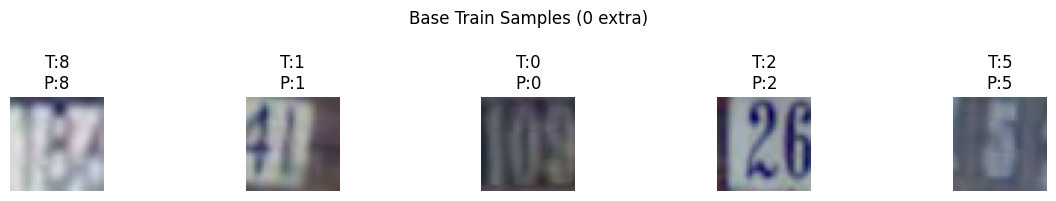

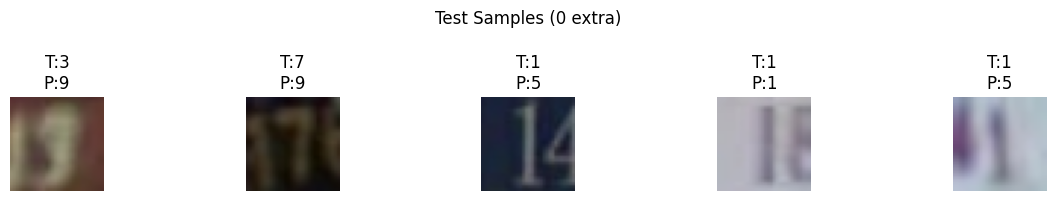

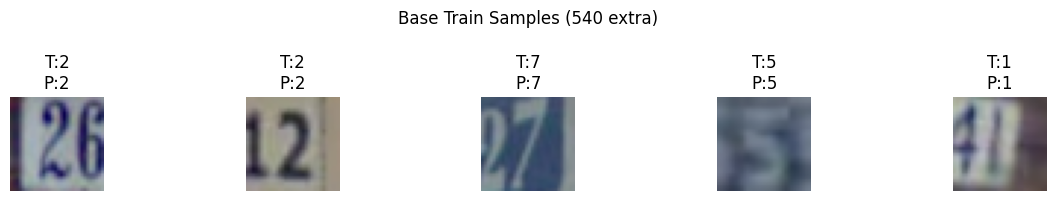

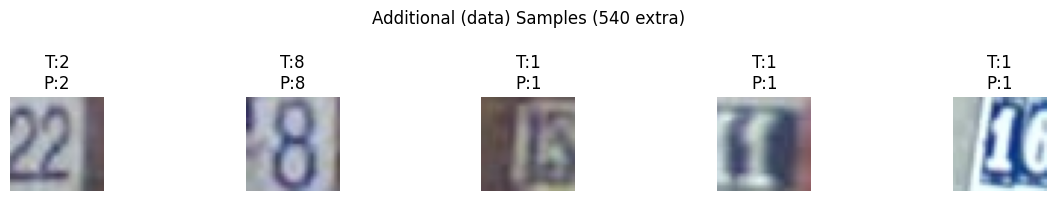

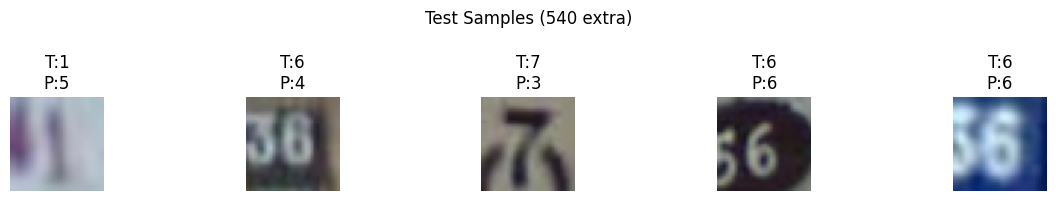

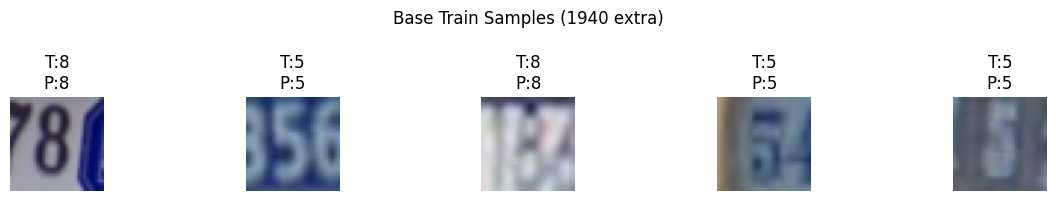

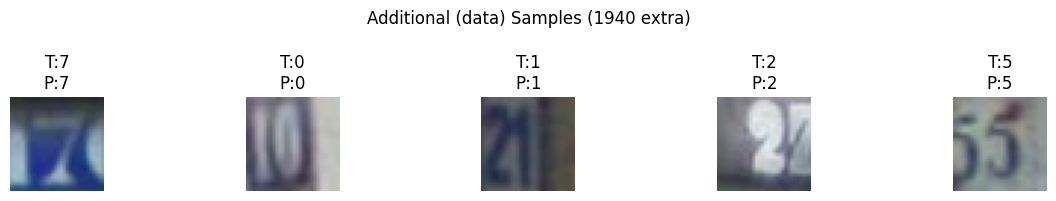

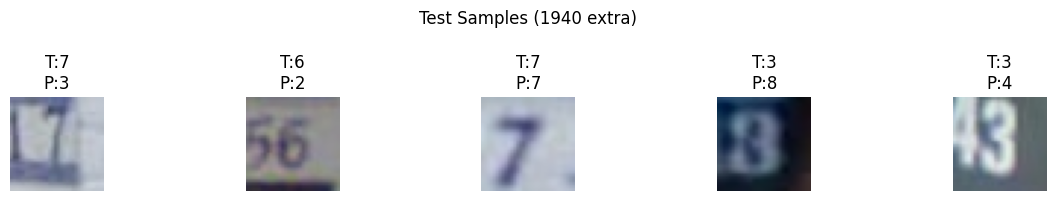

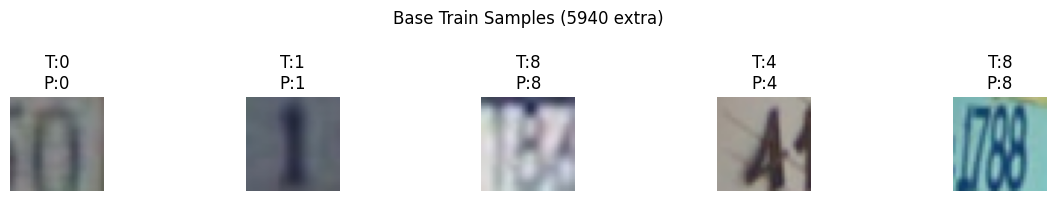

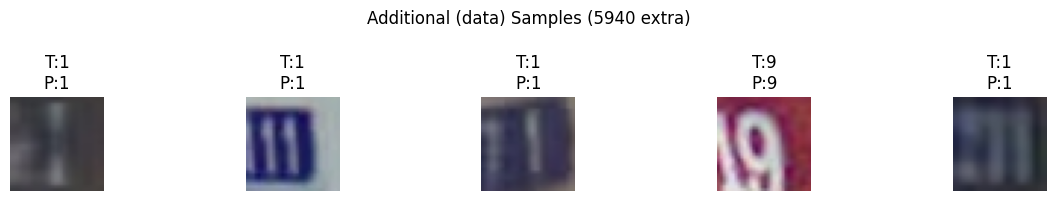

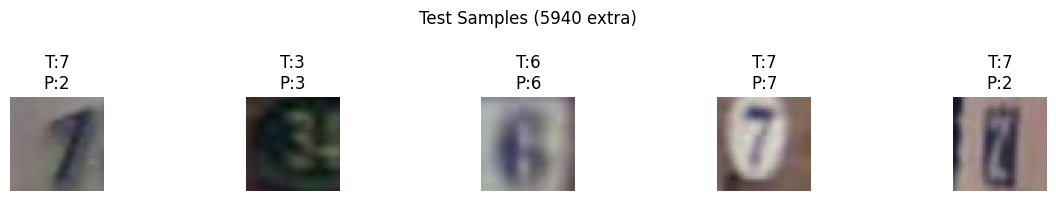

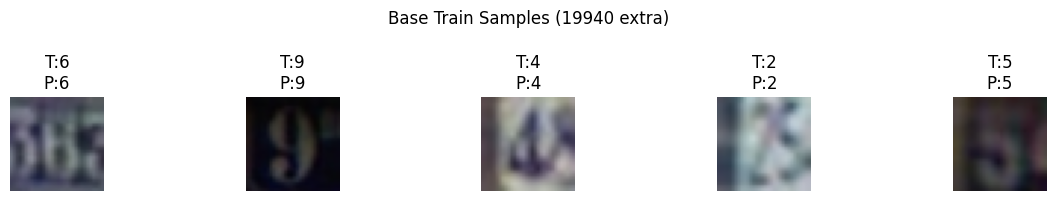

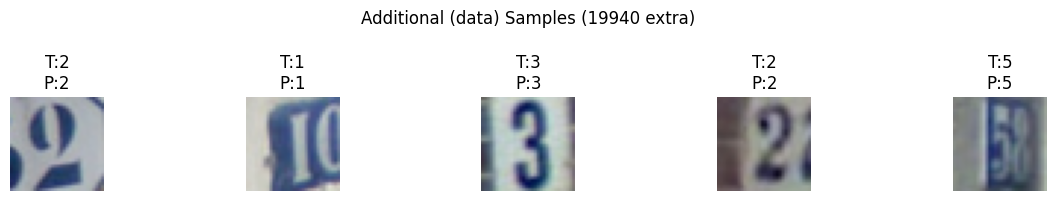

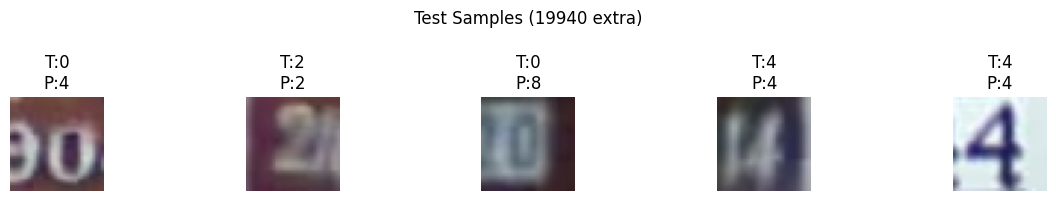

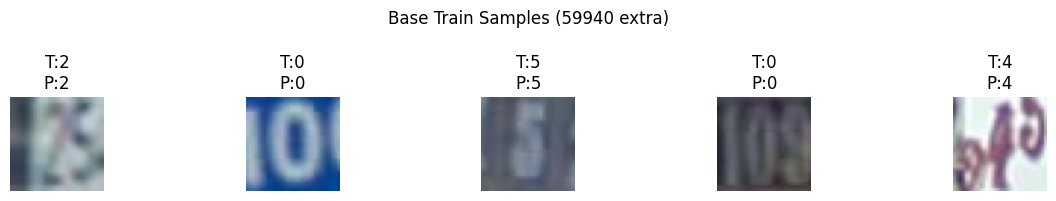

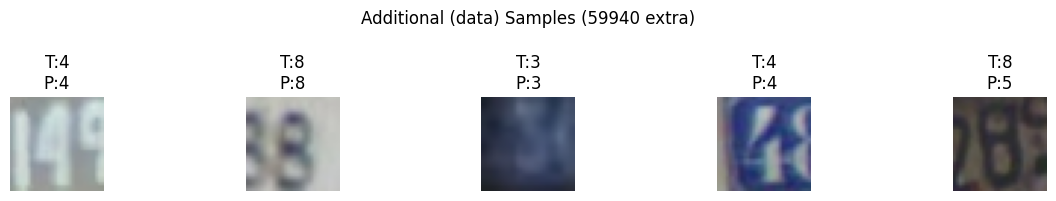

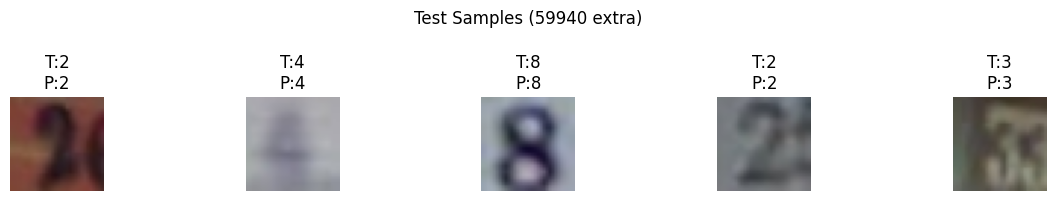

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
